# TFM: Predicción de la demanda energética - Parte 3: Serie temporal de consumo total de la muestra de clientes (CU 1)
#### Lara Palacios

En este caso de uso, vamos a analizar la serie temporal del consumo total de la red de clientes.

## 0. Importación de librerías

In [1]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00


In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 5.6 MB/s eta 0:00:00


In [4]:
!pip install prophet

In [5]:
import pandas as pd
import numpy as np
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from io import StringIO
import contextlib
import re
import gc
import warnings
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster, bayesian_search_forecaster, grid_search_forecaster
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax, grid_search_sarimax

from pmdarima import ARIMA
from pmdarima import auto_arima

from lightgbm import LGBMRegressor
import plotly.graph_objects as go

import shap

from prophet import Prophet

pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

## 3. Preparación de los datos

En este cuaderno trabajaremos solo con la serie temporal de la variable CONSUMO:

In [10]:
variable = 'ENTRADA'

### 3.2. Integridad de la serie temporal

#### 3.2.0. Carga de los datos

In [11]:
#conexión a google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
df_preprocesado = pd.read_parquet('/content/drive/MyDrive/TFM/df_preprocesado_red.parquet')
df_preprocesado.shape

(15140750, 26)

In [13]:
seleccionar_clientes = pd.read_parquet('/content/drive/MyDrive/TFM/seleccionar_clientes.parquet')
seleccionar_clientes.shape

(11137, 4)

Añadiendo condiciones sobre el dataframe 'seleccionar_clientes' podemos descartar a clientes que no cumplan condiciones de integridad.

In [14]:
filtro_clientes = seleccionar_clientes[(seleccionar_clientes['FILAS_NA'] == 0) & (seleccionar_clientes['INICIO'] == seleccionar_clientes['INICIO'].min())].reset_index(drop = True)
filtro_clientes.shape

(9781, 4)

In [15]:
df = df_preprocesado[df_preprocesado['PK_CLIENTE'].isin(filtro_clientes['PK_CLIENTE'])]
df.shape

(13510134, 26)

In [16]:
#para liberar espacio de la RAM en Google Colab
del filtro_clientes
gc.collect()
filtro_clientes=pd.DataFrame()

#### 3.2.1. Formato de serie temporal

Veamos cuantos datos de clientes distintos tenemos para cada día de la serie. Así aseguraremos que tenemos una serie con las mismas condiciones en cada día.

In [17]:
clientes_por_fecha = df.groupby(df.PK_ANYOMESDIA).agg({'PK_CLIENTE': 'nunique'}).rename(columns={'PK_CLIENTE': 'count_PK_CLIENTE'}).reset_index()
clientes_por_fecha['PK_ANYOMESDIA'] = clientes_por_fecha['PK_ANYOMESDIA'].dt.date

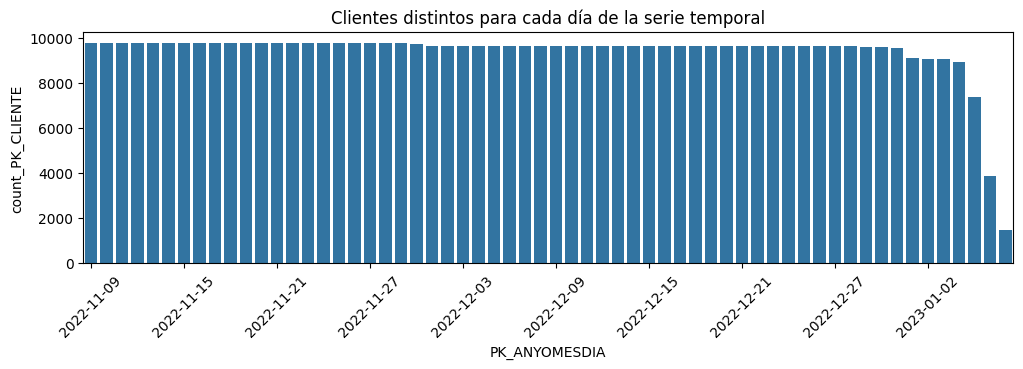

In [18]:
plt.figure(figsize=(12, 3))
sns.barplot(x = "PK_ANYOMESDIA", y = "count_PK_CLIENTE", data = clientes_por_fecha)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
plt.title('Clientes distintos para cada día de la serie temporal')
plt.show()

Vemos que para los últimos días se reduce notablemente el número de clientes para los que tenemos datos. Calculamos los outliers de nuevo con el método del rango intercuartílico y así los eliminamos de nuestra serie temporal.

In [19]:
Q1 = clientes_por_fecha['count_PK_CLIENTE'].quantile(0.25)
Q3 = clientes_por_fecha['count_PK_CLIENTE'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df_filtrado = clientes_por_fecha[(clientes_por_fecha['count_PK_CLIENTE'] >= limite_inferior) & (clientes_por_fecha['count_PK_CLIENTE'] <= limite_superior)]
fecha_min = df_filtrado['PK_ANYOMESDIA'].min()
fecha_max = df_filtrado['PK_ANYOMESDIA'].max()

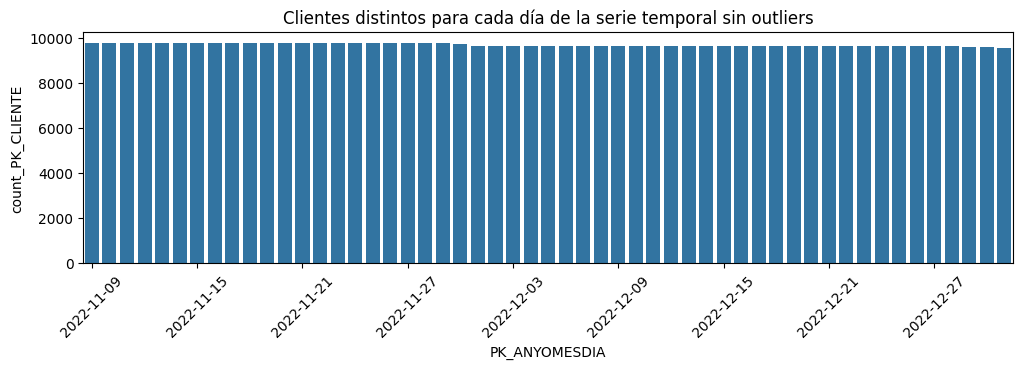

In [20]:
plt.figure(figsize=(12, 3))
sns.barplot(x = "PK_ANYOMESDIA", y = "count_PK_CLIENTE", data = df_filtrado)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
plt.title('Clientes distintos para cada día de la serie temporal sin outliers')
plt.show()

In [21]:
#para liberar espacio de la RAM en Google Colab
del df_filtrado
gc.collect()
df_filtrado=pd.DataFrame()

Así pues, consideraremos solo estos días en nuestra serie temporal del consumo total de la red de clientes. Además, también nos quedamos solo con los clientes que tengan datos para todos estos días.

In [22]:
filtro_clientes_2 = seleccionar_clientes[(seleccionar_clientes['FILAS_NA'] == 0) & (seleccionar_clientes['INICIO'] == seleccionar_clientes['INICIO'].min()) & (seleccionar_clientes['FIN'].dt.date > fecha_max)].reset_index(drop = True)
df = df_preprocesado[df_preprocesado['PK_CLIENTE'].isin(filtro_clientes_2['PK_CLIENTE'])]
df = df[(df['DATETIME'].dt.date >= fecha_min) & (df['DATETIME'].dt.date <= fecha_max)]
df.shape

(11605728, 26)

In [23]:
#para liberar espacio de la RAM en Google Colab
del df_preprocesado
gc.collect()
df_preprocesado=pd.DataFrame()

In [24]:
#para liberar espacio de la RAM en Google Colab
del filtro_clientes_2
gc.collect()
filtro_clientes_2=pd.DataFrame()

Seleccionamos alguna variable más que luego nos servirá para añadir como variable exógena al modelo predictivo:

In [25]:
df['ORTO_minutos'] = df['ORTO'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['OCASO_minutos'] = df['OCASO'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['%_CIELO_DESPEJADO'] = np.where(df['DESCRIPCION'] == 'Despejado',100,0)

In [26]:
df_consumo_total = df.groupby(df['DATETIME']).agg({variable: 'sum', 'TEMPERATURA':'mean', '%_CIELO_DESPEJADO':'mean', 'ORTO_minutos':'mean', 'OCASO_minutos':'mean'})
df_consumo_total = df_consumo_total.asfreq('H')
#df_consumo_total = df_consumo_total.set_index('DATETIME').asfreq('H')

In [27]:
#para liberar espacio de la RAM en Google Colab
del df
gc.collect()
df=pd.DataFrame()

Así obtenemos una serie temporal con los mismos clientes para cada valor del índice. Notar que vamos a trabajar con 9.124 clientes de los 11.786 que teníamos inicialmente.

Con el agrupamiento por la columna DATETIME, ya se establece esta como índice (que es lo que nos interesa). Esta tarea nos facilitará a la hora de hacer futuras operaciones con ella.

Comprobamos ahora que nuestra serie temporal está completa:

In [28]:
(df_consumo_total.index == pd.date_range(start=df_consumo_total.index.min(), end=df_consumo_total.index.max(), freq='H')).all()

True

In [29]:
print(f"Filas con valores ausentes: {df_consumo_total.isnull().any(axis=1).mean()}")

Filas con valores ausentes: 0.0


#### 3.2.2. Variables exógenas

Podemos introducir otras variables de las cuáles podría depender también el consumo de un hogar, y que se incluyen típicamente en análisis de series temporales como son: el día de la semana y el indicador de si es fin de semana o no.
Las usaremos más adelante para cuando queramos incluir variables exógenas a nuestros modelos predictivos.

In [30]:
def minutos_a_formato_h(var_minutos):
    horas = int(var_minutos // 60)
    minutos = int(var_minutos % 60)
    var_formateada = f"{horas:02d}:{minutos:02d}"
    var_formateada = pd.to_datetime(var_formateada, format='%H:%M').hour
    return var_formateada

In [31]:
#variables de calendario
df_consumo_total['HORA'] = df_consumo_total.index.hour #+1
df_consumo_total['DIA_SEMANA'] = df_consumo_total.index.dayofweek #+1
df_consumo_total['FIN_DE_SEMANA'] = (df_consumo_total['DIA_SEMANA'] >= 5).astype(int)
#variables de luz solar
df_consumo_total['H_LUZ_SOLAR'] = (df_consumo_total['OCASO_minutos'] - df_consumo_total['ORTO_minutos'])
df_consumo_total['H_LUZ_SOLAR'] = df_consumo_total['H_LUZ_SOLAR'].apply(minutos_a_formato_h)
df_consumo_total['ORTO'] = df_consumo_total['ORTO_minutos'].apply(minutos_a_formato_h)
df_consumo_total['OCASO'] = df_consumo_total['OCASO_minutos'].apply(minutos_a_formato_h)
df_consumo_total["ES_DE_DIA"] = np.where((df_consumo_total.index.hour>df_consumo_total["ORTO"]) & (df_consumo_total.index.hour<df_consumo_total["OCASO"]),1,0)
df_consumo_total = df_consumo_total.drop(columns = ['OCASO_minutos', 'ORTO_minutos'])

In [32]:
df_consumo_total.head()

ENTRADA  TEMPERATURA  %_CIELO_DESPEJADO  HORA  \
DATETIME                                                              
2022-11-09 00:00:00  7166.134    14.036716           2.444103     0   
2022-11-09 01:00:00  6726.112    13.749014           0.997370     1   
2022-11-09 02:00:00  6455.232    14.103354           1.446734     2   
2022-11-09 03:00:00  6415.334    13.727970           0.230162     3   
2022-11-09 04:00:00  6563.574    13.342722           0.295923     4   

                     DIA_SEMANA  FIN_DE_SEMANA  H_LUZ_SOLAR  ORTO  OCASO  \
DATETIME                                                                   
2022-11-09 00:00:00           2              0           10     7     17   
2022-11-09 01:00:00           2              0           10     7     17   
2022-11-09 02:00:00           2              0           10     7     17   
2022-11-09 03:00:00           2              0           10     7     17   
2022-11-09 04:00:00           2              0           10     7     17   

                     ES_DE_DIA  
DATETIME                        
2022-11-09 00:00:00          0  
2022-11-09 01:00:00          0  
2022-11-09 02:00:00          0  
2022-11-09 03:00:00          0  
2022-11-09 04:00:00          0

In [33]:
#Crear dataframe variables exógenas
exog_cols = ['TEMPERATURA', '%_CIELO_DESPEJADO', 'FIN_DE_SEMANA', 'H_LUZ_SOLAR', 'ES_DE_DIA']

Una vez tenemos ya extraídas todas las variables exógenas que nos interesan, hagamos algunos pasos adicionales.

##### Variables con patrones cíclicos

Algunos aspectos del calendario, como las horas o los días, son cíclicos. Así, este tipo de variables pueden transformarse para captar la ciclicidad de estos datos, utilizando el seno y el coseno de su periodo, y evitar imponer un orden lineal.

In [34]:
def codificacion_ciclica(datos, longitud_ciclo): #Se asume que el valor mínimo de la variable es 0
    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({f"{datos.name}_seno": seno, f"{datos.name}_coseno": coseno})
    return resultado

DIA_SEMANA_encoded = codificacion_ciclica(df_consumo_total['DIA_SEMANA'], longitud_ciclo=7)
HORA_encoded = codificacion_ciclica(df_consumo_total['HORA'], longitud_ciclo=24)
ORTO_encoded = codificacion_ciclica(df_consumo_total['ORTO'], longitud_ciclo=24)
OCASO_encoded = codificacion_ciclica(df_consumo_total['OCASO'], longitud_ciclo=24)
variables_ciclicas = pd.concat([DIA_SEMANA_encoded, HORA_encoded,ORTO_encoded,OCASO_encoded], axis=1)
df_consumo_total = pd.concat([df_consumo_total, variables_ciclicas], axis=1)

In [35]:
exog_cols.extend(df_consumo_total.filter(regex='_seno$|_coseno$').columns.tolist())

##### Interacción entre variables

En ocasiones, las variables exógenas no son independientes. Podemos capturar esta interacción mediante nuevas variables (que se obtienen multiplicando entre sí las variables existentes).

In [36]:
transformer_poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False).set_output(transform="pandas")
poly_cols = ['FIN_DE_SEMANA','DIA_SEMANA_seno','DIA_SEMANA_coseno','HORA_seno','HORA_coseno','H_LUZ_SOLAR','ES_DE_DIA','ORTO_seno','ORTO_coseno','OCASO_seno','OCASO_coseno']

variables_poly = transformer_poly.fit_transform(df_consumo_total[poly_cols].dropna()).drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
df_consumo_total = pd.concat([df_consumo_total, variables_poly], axis=1)

In [37]:
exog_cols.extend(df_consumo_total.filter(regex='^poly_.*').columns.tolist())

#### 3.2.3. Separación de los datos en conjuntos de train, validation y test

Para poder optimizar los hiperparámetros del modelo y evaluar su capacidad predictiva, se dividen los datos en 3 conjuntos, uno de entrenamiento, uno de validación y otro de test.

Notar que en el caso de series temporales no hay que aislar la variable target del resto, pues los valores pasados de esta variable se utilizan para su predicción.

In [38]:
df_consumo_total['DIA'] = df_consumo_total.index.date
dias = df_consumo_total['DIA'].unique()
n_dias = len(dias)

dias_train = int(n_dias * 0.6)
dias_validation = int(n_dias * 0.3)
dias_test = n_dias - dias_train - dias_validation

train_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[:dias_train])]
validation_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[dias_train:dias_train + dias_validation])]
test_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[dias_train + dias_validation:])]

print("---Serie temporal del consumo total de la red de clientes---")
print(f"Fechas train      : {train_data.index.min()} --- {train_data.index.max()}  (n={len(train_data)})")
print(f"Fechas validacion : {validation_data.index.min()} --- {validation_data.index.max()}  (n={len(validation_data)})")
print(f"Fechas test       : {test_data.index.min()} --- {test_data.index.max()}  (n={len(test_data)})")

---Serie temporal del consumo total de la red de clientes---
Fechas train      : 2022-11-09 00:00:00 --- 2022-12-09 23:00:00  (n=744)
Fechas validacion : 2022-12-10 00:00:00 --- 2022-12-24 23:00:00  (n=360)
Fechas test       : 2022-12-25 00:00:00 --- 2022-12-31 23:00:00  (n=168)


In [39]:
#eliminar columna DIA

## 4. Exploración gráfica

### 4.1. Representación gráfica de la serie temporal
Con separación de datos de train, validación y test.

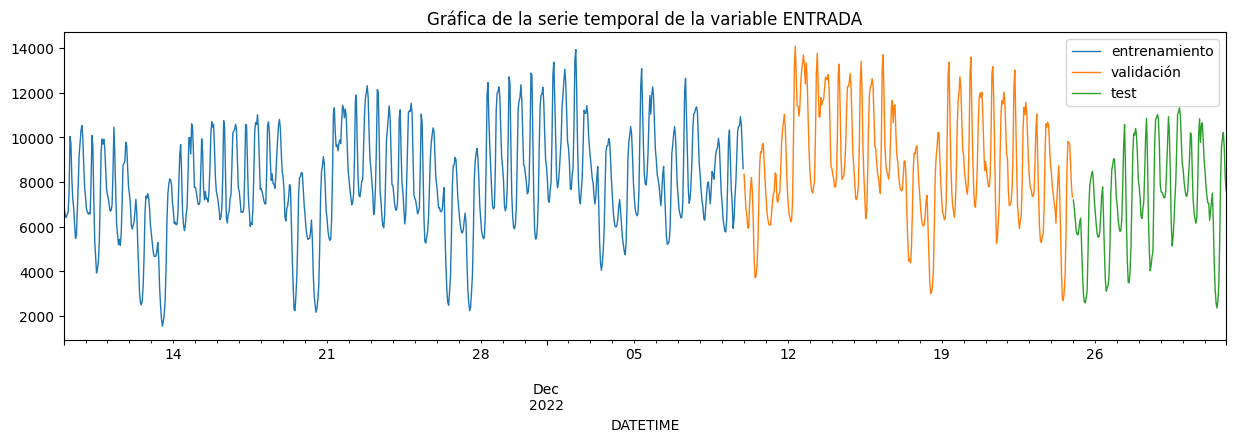

In [40]:
fig, ax = plt.subplots(figsize=(15, 4))
train_data[variable].plot(ax=ax, label= 'entrenamiento', linewidth=1)
validation_data[variable].plot(ax=ax, label= 'validación', linewidth=1)
test_data[variable].plot(ax=ax, label= 'test', linewidth=1)
ax.set_title(f'Gráfica de la serie temporal de la variable {variable}')
ax.legend()

Observaciones.
- La serie muestra una clara periodicidad, con picos y valles regulares que podrían corresponder a ciclos diarios de consumo eléctrico. También se pueden observar levemente los ciclos semanales de consumo.
- Existen variaciones significativas en los valores de la variable consumo.

### 4.2. Distribución de la carga por día de la semana

Text(0.5, 0.98, '')

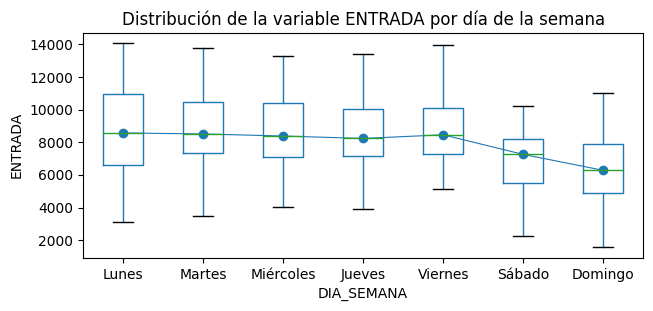

In [41]:
fig, ax = plt.subplots(figsize=(7, 3))
df_consumo_total.boxplot(column=variable, by='DIA_SEMANA', ax=ax, grid=False)
medianas = df_consumo_total.groupby('DIA_SEMANA')[variable].median()
medianas.index = medianas.index + 1
medianas.plot(style='o-', linewidth=0.8, ax=ax)
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
plt.xticks(ticks=range(1,8), labels=dias_semana)
ax.set_ylabel(variable)
ax.set_title(f'Distribución de la variable {variable} por día de la semana')
fig.suptitle('')

Observaciones.
- El consumo tiende a mantenerse relativamente constante.
- La altura de la caja es similar para todos los días, indicando una dispersión similar del consumo.
- Hay una cantidad significativa de outliers negativos. Esto se debe a los picos de producción de energía solar en la variable SALIDA, que afectan en CONSUMO.
- Se observa un menor consumo de electricidad los fines de semana.

### 4.3. Distribución de la carga por hora del día

Text(0.5, 0.98, '')

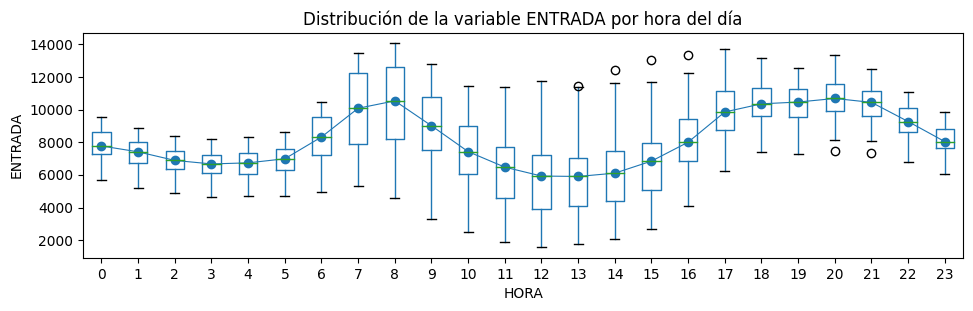

In [42]:
fig, ax = plt.subplots(figsize=(11, 3))
df_consumo_total['HORA'] = df_consumo_total.index.hour
df_consumo_total.boxplot(column=variable, by='HORA', ax=ax)
medianas = df_consumo_total.groupby('HORA')[variable].median()
medianas.index = medianas.index + 1
medianas.plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel(variable)
ax.set_title(f'Distribución de la variable {variable} por hora del día')
fig.suptitle('')

Observaciones.
- El consumo de energía tiene dos picos principales: uno por la mañana alrededor de las 8 horas y otro por la tarde entre las 18 y las 20 horas. Esto es debido probablemente a los momentos de mayor actividad en los hogares, como el inicio del día y las horas de la tarde-noche cuando las personas vuelven a casa.
- La variabilidad en el consumo de energía es mayor durante los picos de actividad y menor durante la noche.
- Notar también que los periodos de menor consumo coinciden con las horas de mayor radiación solar (las horas centrales del día). Lo cual podría indicar que durante estas horas, la producción solar podría estar cubriendo una mayor parte de la demanda, reduciendo la necesidad de consumo de la red y llegando a producir hasta un excedente (ya que hay bastantes valores negativos).

## 5. Creación y entrenamiento del modelo

### 5.0. Definición de funciones necesarias

In [43]:
train_val_data = pd.concat([train_data, validation_data], axis=0)

In [44]:
tabla_comparacion_modelos = pd.DataFrame(columns=['Modelo', 'Tiempo de ejecución', 'Variables exógenas', 'refit', 'MAE', 'MSE', 'RMSE'])

def guardar_results(modelo, tiempo, mae, mse, rmse, tabla_comparacion_modelos, var_exog = 'No', refit = 'No'):
  tabla_comparacion_modelos = pd.concat([tabla_comparacion_modelos, pd.DataFrame({'Modelo': modelo, 'Tiempo de ejecución': tiempo, 'Variables exógenas': var_exog, 'refit': refit, 'MAE': mae.round(1), 'MSE': mse.round(1), 'RMSE': rmse.round(1)}, index=[0])], ignore_index=True)
  return tabla_comparacion_modelos

In [45]:
def all_metrics(prediccion, test_data):
    metrics = {}
    metrics['MAE'] = mean_absolute_error(test_data[variable], prediccion)
    metrics['MSE'] = mean_squared_error(test_data[variable], prediccion)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    return metrics

In [114]:
def backtesting(forecaster, df, train_data, test_data, grafica = True, refit = False, exog_cols = None):
    inicio = time.time()

    if exog_cols is not None:
        exog = df[exog_cols]
    else:
        exog = None
    if refit == False:
      fixed_train_size = True
    elif refit == True:
      fixed_train_size = False
    params = {
        'forecaster': forecaster,
        'y': df[variable],
        'exog': exog,
        'steps': 24,
        'metric': 'mean_absolute_error',
        'initial_train_size': len(df[variable].loc[:train_data.index.max()]),
        'n_jobs': 'auto',
        'verbose': False,
        'show_progress': True,
        'fixed_train_size': fixed_train_size,
        'refit': refit
    }
    if isinstance(forecaster, ForecasterSarimax):
        metric, predictions = backtesting_sarimax(**params)
    else:
        metric, predictions = backtesting_forecaster(**params)

    fin = time.time()
    tiempo = fin-inicio
    print(f"Tiempo de ejecución: {tiempo}")

    metrics = all_metrics(predictions, test_data)
    print(f"Métricas de error: {metrics}")

    if grafica == True:
      fig, ax = plt.subplots(figsize=(11, 3))
      train_data[variable].plot(ax=ax, label='train', color = '#1f77b4')
      # color para el de validación '#ff7f0e'
      test_data[variable].plot(ax=ax, label='test', color = '#2ca02c')
      predictions.plot(ax=ax, label='predicciones', color = '#FF0000')
      ax.set_title(f'Predicción sobre la variable {variable}')
      ax.legend()

    print("--------------------------------")
    return metrics, tiempo, predictions

In [47]:
def importancia_features(forecaster, df, train_data):
  forecaster.fit(y = df.loc[:train_data.index.max(), variable], exog = df.loc[:train_data.index.max(), exog_cols])
  feature_importances = forecaster.get_feature_importances()
  feature_importances['%_importance'] = ((feature_importances['importance'] / feature_importances['importance'].sum()) * 100).round(2)
  feature_importances = feature_importances.sort_values(by='%_importance', ascending=False).head(10)
  return feature_importances

In [48]:
def shap_values(forecaster, train_data):
  X_train, y_train = forecaster.create_train_X_y(y=train_val_data[variable]) # Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor

  params = forecaster.regressor.get_params()
  params['predict_disable_shape_check'] = True
  forecaster.regressor = LGBMRegressor(**params)
  forecaster.regressor.fit(X_train, y_train)

  explainer = shap.TreeExplainer(forecaster.regressor)
  # Se selecciona una muestra del 50% de los datos para acelerar el cálculo
  rng = np.random.default_rng(seed=785412)
  sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
  X_train_sample = X_train.loc[sample, :]
  shap_values = explainer.shap_values(X_train_sample)

  shap.initjs()
  shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
  fig, ax = plt.gcf(), plt.gca()
  ax.set_title("SHAP Summary plot")
  ax.tick_params(labelsize=8)
  fig.set_size_inches(6, 3.5)
  plt.show()

### 5.1. Baseline

La librería *Skforecast* facilita la creación de un baseline utilizando su clase *ForecasterEquivalentDate*. Este modelo simplemente devuelve el valor observado en el mismo período de la temporada anterior. En este caso, el modelo predice el valor del día siguiente utilizando el valor de la misma hora y del mismo día de la semana anterior.

Una vez entrenado el modelo, evaluaremos su capacidad predictiva mediante un proceso de backtesting.

In [49]:
params = {
    'offset': pd.DateOffset(days=7),
    'n_offsets': 1
}
baseline = ForecasterEquivalentDate(**params)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.1180262565612793
Métricas de error: {'MAE': 1311.9737738095237, 'MSE': 3132529.512306226, 'RMSE': 1769.8953393650784}
--------------------------------


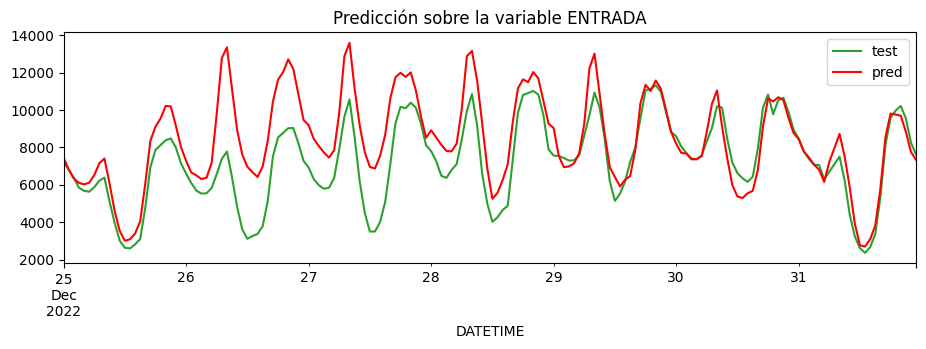

In [50]:
metrics, tiempo = backtesting(baseline, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterEquivalentDate({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Una vez tenemos un baseline, probemos a modelar la serie mediante un tipo de modelo estadístico muy usado para series temporales: ARIMA y sus variantes.

### 5.2. ARIMA (AutoRegressive Integrated Moving Average)

#### 5.2.1. Análisis exploratorio de la serie

Antes de aplicar ARIMA, es necesario:

1. **Verificar Estacionariedad**

Observando la gráfica de la serie temporal, parece que la media y la varianza permanencen más o menos constantes, lo cuál es un indicador de estacionaridad. Pero para asegurarnos, aplicaremos la prueba de **Dickey Fuller aumentada** y la de **Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**.

In [51]:
def test_estacionariedad(df): ## tengo dudas sobre si esto se aplica sobre todo el conjunto o solo sobre el de train
    print(f'Test estacionariedad para la serie de la variable {variable}')
    print('--------------------------------------------------------------')
    adfuller_result = adfuller(df[variable])
    kpss_result = kpss(df[variable])
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

In [52]:
test_estacionariedad(train_val_data)

Test estacionariedad para la serie de la variable ENTRADA
--------------------------------------------------------------
ADF Statistic: -2.1383822211000236, p-value: 0.2293635089656536
KPSS Statistic: 1.0560329219211437, p-value: 0.01


Notar que para la prueba DF el p-value > 0.05 y para la de KPSS el p-value < 0.05, luego se considera que la serie es estacionarias y es necesario diferenciar.

In [53]:
train_data_diff_1 = train_val_data.diff().dropna()

In [54]:
test_estacionariedad(train_data_diff_1)

Test estacionariedad para la serie de la variable ENTRADA
--------------------------------------------------------------
ADF Statistic: -9.103472535667732, p-value: 3.5538644305717535e-15
KPSS Statistic: 0.012382997287486094, p-value: 0.1


Ahora los valores de los p-values si que están en el umbral que deben estar. Por lo tanto:

In [55]:
d = 1

Pintemos las gráficas de las series diferenciadas:

<Axes: title={'center': 'Diferenciación de orden 1 de la serie de la variable ENTRADA'}, xlabel='DATETIME'>

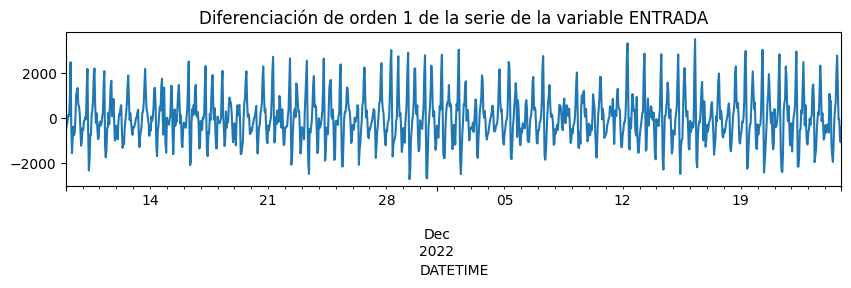

In [56]:
fig, ax = plt.subplots(figsize=(10, 2))
train_data_diff_1[variable].plot(ax=ax, title=f'Diferenciación de orden 1 de la serie de la variable {variable}')

Los análisis posteriores debemos realizarlos con la serie diferenciada.

2. **Análisis de autocorrelación**

La ACF ayuda a identificar el valor de $q$ (lags en la parte de media móvil), mientras que la PACF ayuda a identificar el valor de $p$ (lags en la parte autorregresiva).

- El umbral de significancia en un gráfico de autocorrelación se refiere a las líneas horizontales que se dibujan a una distancia de ±1.96/√n (donde n es el número de observaciones) alrededor del valor cero. Estas líneas delimitan una región donde los valores de autocorrelación se consideran no significativamente diferentes de cero. Así, los valores que se encuentran dentro de estas líneas se consideran ruido blanco, es decir, no proporcionan información útil sobre la estructura de la serie temporal.

- Se dice que la función de autocorrelación corta significativamente en el lag i, cuando el valor de la autocorrelación en el lag i está fuera del umbral de significancia.

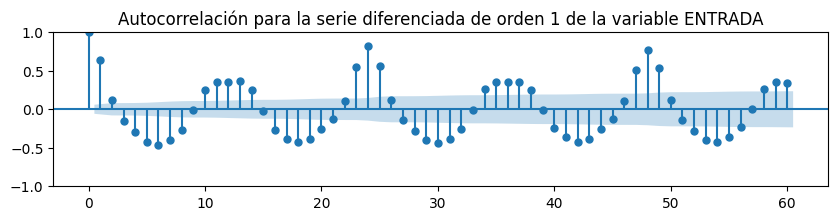

In [57]:
fig, ax = plt.subplots(figsize=(10, 2))

plot_acf(train_data_diff_1[variable], ax=ax, lags=60)
ax.set_title(f'Autocorrelación para la serie diferenciada de orden 1 de la variable {variable}')
plt.show()

La ACF muestra un patrón sinusoidal, lo cual podría indicar la presencia de una componente estacional. Las correlaciones significativas a múltiples lags indican que hay una dependencia temporal a lo largo del tiempo.

El lag en el que la ACF cruza el umbral de significancia proporciona una estimación del valor de $q$:

In [58]:
q = 3

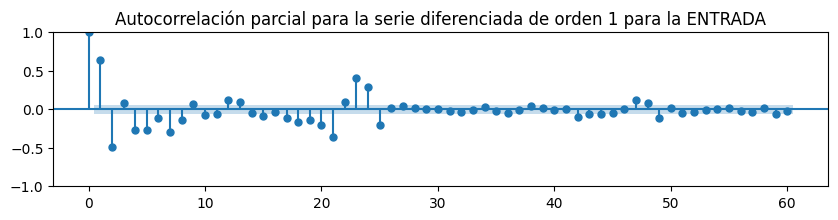

In [59]:
fig, ax = plt.subplots(figsize=(10, 2))
plot_pacf(train_data_diff_1[variable], ax=ax, lags=60, method='ywm')
ax.set_title(f'Autocorrelación parcial para la serie diferenciada de orden 1 para la {variable}')
plt.show()

En la gráfica de autocorrelación parcial (PACF), los primeros lags muestran correlaciones significativas, lo cual indica que hay una relación directa entre los valores actuales y los valores pasados en esos lags específicos.
Después de los primeros lags, las correlaciones se vuelven insignificantes rápidamente, hasta llegar a las siguientes 24h o 48h que vuelve a haber un pequeño repunte. Esto sugiere que seguramente exista estacionalidad en los datos.

Notar que los valores de la PACF caen dentro del umbral de no significancia a partir del lag 3, indicando que el modelo ARIMA podría tener un término AR:

In [60]:
p = 3

#### 5.2.2. Creación y entrenamiento del modelo

In [61]:
def modelo_ARIMA(train_data, test_data, p, d, q):
    inicio = time.time()
    params = {
        'order': (p, d, q)
    }
    modelo = ARIMA(**params)
    model_fit = modelo.fit(train_data[variable])
    predicciones = model_fit.predict(n_periods=len(test_data[variable]))
    forecast = model_fit.predict(n_periods=len(test_data[variable]), return_conf_int=False)

    metrics = all_metrics(predicciones, test_data)
    print(f"Métricas de error: {metrics}")

    fig, ax = plt.subplots(figsize=(11, 3))
    train_data[variable].plot(ax=ax, label='train', color = '#1f77b4')
    test_data[variable].plot(ax=ax, label='test', color = '#2ca02c')
    predicciones.plot(ax=ax, label='pred', color = '#FF0000')
    ax.set_title(f'Predicciones con ARIMA para la variable {variable}')
    ax.legend()

    fin = time.time()
    tiempo = fin-inicio
    return params, metrics, tiempo

Métricas de error: {'MAE': 1820.0357629749265, 'MSE': 5135039.229085787, 'RMSE': 2266.062494523438}


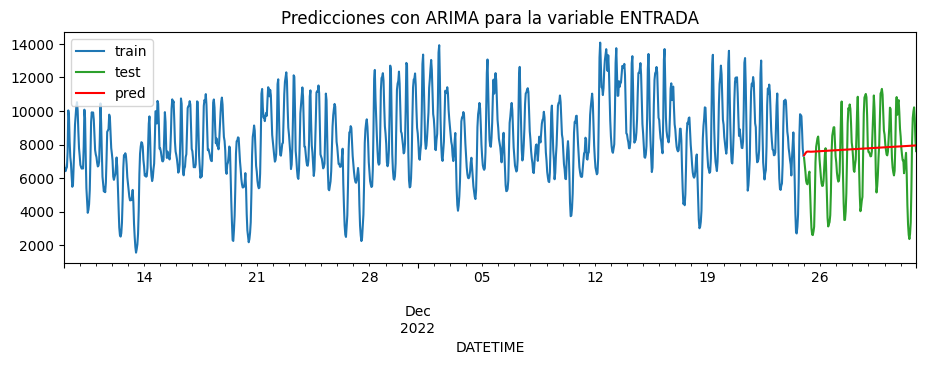

In [62]:
params, metrics, tiempo = modelo_ARIMA(train_val_data, test_data, p, d, q)
tabla_comparacion_modelos = guardar_results(f'ARIMA({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Los resultados con modelos ARIMA son muy malos, peores incluso que los obtenidos con el modelo baseline. Notar que las predicciones son casi planas. Puede que se deba a la existente estacionalidad de los datos. Deberemos modelar también la componente estacional con SARIMA.

### 5.3. SARIMA (Seasonal ARIMA)

SARIMA es una extensión de ARIMA que incluye componentes estacionales. Ideal para datos que muestran estacionalidad, como el consumo eléctrico que hemos visto que sigue un ciclo diario.

#### 5.3.1. Análisis exploratorio de la serie

Como hemos detectado que nuestras series tienen estacionalidad, será útil realizar una descomposición estacional de series temporales (STL), es decir, descomponer la serie temporal en sus componentes fundamentales para un análisis más detallado:

- La tendencia
- La estacionalidad
- Los residuos

Este análisis puede revelar patrones ocultos y ayudar a identificar la estacionalidad, además de los valores óptimos de los parámetros $P$, $D$, $Q$ y $s$ (y puede llevarse a cabo de manera aditiva o multiplicativa).

In [63]:
def descomposicion_estacional(df):
    res_decompose = seasonal_decompose(df[variable], model='additive', extrapolate_trend='freq')

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
    res_decompose.observed.plot(ax=axs[0, 0])
    axs[0, 0].set_title('Serie')
    res_decompose.trend.plot(ax=axs[0, 1])
    axs[0, 1].set_title('Tendencia')
    res_decompose.seasonal.plot(ax=axs[1, 0])
    axs[1, 0].set_title('Estacionalidad')
    res_decompose.resid.plot(ax=axs[1, 1])
    axs[1, 1].set_title('Residuos')
    fig.suptitle(f'Descomposición estacional de la serie para la variable {variable}', fontsize=14)
    fig.tight_layout()

    return res_decompose

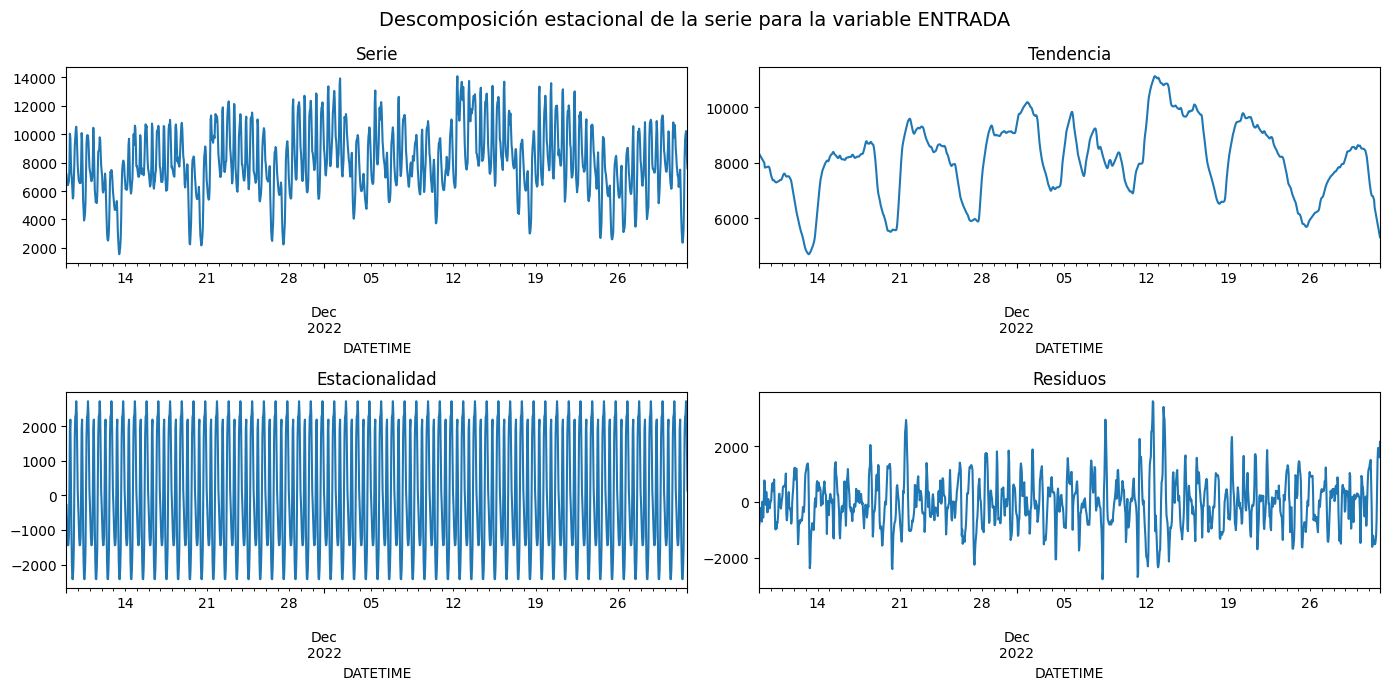

In [64]:
descomposicion_estacional(df_consumo_total)

- La estacionalidad muestra un patrón muy claro con ciclos regulares de 24 horas (lags) en las tres series temporales. De aquí se sigue el valor de s.

- En las gráficas de tendencia se puede apreciar una tendencia decreciente.

In [65]:
s = 24

#### 5.3.2. Creación y entrenamiento del modelo ForecasterSarimax

In [66]:
P, D, Q = 1,1,1

Probaremos a aplicar el modelo SARIMA con las dos librerías que lo tienen tanto skforecast como pmdarima.

In [74]:
params = {
        'order': (p, d, q),
        'seasonal_order': (P, D, Q, s),
        'enforce_stationarity': False
    }
forecaster_skforecast = ForecasterSarimax(regressor=Sarimax(**params)) #maxiter=200
#forecaster_pmdarima = ForecasterSarimax(regressor=ARIMA(**params))

In [68]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, grafica = False)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 110.35706853866577
Métricas de error: {'MAE': 1224.554862483933, 'MSE': 2744619.402576128, 'RMSE': 1656.689289690776}
--------------------------------


In [69]:
# metrics, tiempo = backtesting(forecaster_pmdarima, df_consumo_total, train_val_data, test_data, grafica = False)
# tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=ARIMA({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

##### Con reentrenamiento

In [75]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, grafica = False, refit = True)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si')

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 364.90546107292175
Métricas de error: {'MAE': 1022.6009712878388, 'MSE': 1832809.9810217272, 'RMSE': 1353.813126329379}
--------------------------------


In [ ]:
# metrics, tiempo = backtesting(forecaster_pmdarima, df_consumo_total, train_val_data, test_data, grafica = False, refit = True)
# tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=ARIMA({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si')

##### Con variables exógenas

In [112]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, exog_cols = exog_cols)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, var_exog = 'Si')

KeyboardInterrupt: 

In [ ]:
# metrics, tiempo = backtesting(forecaster_pmdarima, df_consumo_total, train_val_data, test_data, grafica = False, exog_cols = exog_cols)
# tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=ARIMA({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, var_exog = 'Si')

##### Con reentrenamiento y variables exógenas

In [77]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, grafica = False, refit = True, exog_cols = exog_cols)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si', var_exog = 'Si')

KeyboardInterrupt: 

In [ ]:
# metrics, tiempo = backtesting(forecaster_pmdarima, df_consumo_total, train_val_data, test_data, grafica = False, refit = True, exog_cols = exog_cols)
# tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=ARIMA({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si', var_exog = 'Si')

Con el ForecasterSarimax y usando como regresor Sarimax(), hemos conseguido obtener un MAE ligeramente inferior al obtenido con el baseline.

Nos queda margen para ajustar los parámetros, sobre todo en $P$, $D$ y $Q$.

#### 5.3.3. Búsqueda exhaustiva de hiperparámetros

Dado que Auto-ARIMA es una estrategia de búsqueda de mucho más rápida, es una buena opción utilizarla como primer paso para identificar un grupo inicial de modelos candidatos. Para, posteriormente comparar los candidatos finales utilizando backtesting.

Nota: Es fundamental llevar a cabo la optimización de hiperparámetros utilizando un conjunto de datos de validación, en lugar del conjunto de datos de test.

##### ***Auto-ARIMA***

In [78]:
def auto_ARIMA(df, train_data, d):
  buffer = StringIO()
  with contextlib.redirect_stdout(buffer):
      auto_arima(
              y                 = df[variable].loc[:train_data.index.max()],
              start_p           = 0,
              start_q           = 0,
              max_p             = 5,
              max_q             = 5,
              seasonal          = True,
              test              = 'adf',
              m                 = 24, # periodicidad de la estacionalidad
              d                 = d,
              D                 = None, # El algoritmo determina 'D'
              trace             = True,
              error_action      = 'ignore',
              suppress_warnings = True,
              stepwise          = True
          )
  trace_autoarima = buffer.getvalue()
  pattern = r"ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec"
  matches = re.findall(pattern, trace_autoarima)
  results = pd.DataFrame(matches, columns=["p", "d", "q", "P", "D", "Q", "s", "intercept", "AIC", "Time"])
  results["order"] = results[["p", "d", "q"]].apply(lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]})", axis=1)
  results["seasonal_order"] = results[["P", "D", "Q", "s"]].apply(lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]},{x.iloc[3]})", axis=1)
  results = results[["order", "seasonal_order", "intercept", "AIC", "Time"]]
  results["AIC"] = results["AIC"].astype('float64')
  results_auto_arima = results.sort_values(by="AIC").reset_index(drop=True)
  results_auto_arima.to_csv(f'/content/drive/MyDrive/TFM/auto_arima_{variable}.csv', index=False)

  return results_auto_arima

In [79]:
try:
  results_auto_arima = pd.read_csv(f'/content/drive/MyDrive/TFM/auto_arima_{variable}.csv')
except FileNotFoundError:
  results_auto_arima = auto_ARIMA(df_consumo_total, train_val_data, None) #None

In [80]:
results_auto_arima.head()

order seasonal_order  intercept        AIC   Time
0  (1,0,1)     (1,0,1,24)  intercept  16522.414  13.31
1  (1,0,1)     (2,0,0,24)  intercept  16633.462  36.83
2  (1,0,1)     (1,0,2,24)  intercept  16752.631  29.21
3  (1,0,1)     (1,0,0,24)  intercept  16755.412  11.61
4  (1,0,2)     (1,0,1,24)  intercept  16797.160  12.82

Ahora aplicamos backtesting sobre los modelos con las configuraciones recomendadas por auto-ARIMA:

In [81]:
i = 0
rmse_aux = 1000000000
params_best = {'order': (0,0,0)}
tiempo_best = 1.0
metrics_best = {}

while i <10:
  params = {
          'order': eval(results_auto_arima['order'][i]),
          'seasonal_order': eval(results_auto_arima['seasonal_order'][i]),
          'enforce_stationarity': False
      }
  forecaster = ForecasterSarimax(regressor=Sarimax(**params)) #,maxiter=200
  print(params)
  metrics, tiempo = backtesting(forecaster, df_consumo_total, train_val_data, test_data, grafica = False)
  if rmse_aux > metrics['RMSE']:
    params_best = params
    tiempo_best = tiempo
    metrics_best = metrics
  i = i + 1

tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params_best})', tiempo_best, metrics_best['MAE'], metrics_best['MSE'], metrics_best['RMSE'], tabla_comparacion_modelos, var_exog = True)

{'order': (1, 0, 1), 'seasonal_order': (1, 0, 1, 24), 'enforce_stationarity': False}


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 6.323568344116211
Métricas de error: {'MAE': 1075.040220597977, 'MSE': 2142052.515598916, 'RMSE': 1463.5752510885513}
--------------------------------
{'order': (1, 0, 1), 'seasonal_order': (2, 0, 0, 24), 'enforce_stationarity': False}


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 9.830010652542114
Métricas de error: {'MAE': 1103.2819364927013, 'MSE': 1985281.1320280265, 'RMSE': 1409.0000468516764}
--------------------------------
{'order': (1, 0, 1), 'seasonal_order': (1, 0, 2, 24), 'enforce_stationarity': False}


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 32.69374370574951
Métricas de error: {'MAE': 1049.5473548116938, 'MSE': 2212132.2425648826, 'RMSE': 1487.323852617473}
--------------------------------
{'order': (1, 0, 1), 'seasonal_order': (1, 0, 0, 24), 'enforce_stationarity': False}


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.565535306930542
Métricas de error: {'MAE': 1053.0422111687474, 'MSE': 1883053.082513023, 'RMSE': 1372.2438130715047}
--------------------------------
{'order': (1, 0, 2), 'seasonal_order': (1, 0, 1, 24), 'enforce_stationarity': False}


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 9.273093223571777
Métricas de error: {'MAE': 1156.50335499738, 'MSE': 2518153.130538115, 'RMSE': 1586.8689708158374}
--------------------------------
{'order': (2, 0, 2), 'seasonal_order': (1, 0, 1, 24), 'enforce_stationarity': False}


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 8.938581943511963
Métricas de error: {'MAE': 1344.7045511412548, 'MSE': 3393762.546053187, 'RMSE': 1842.2167478484141}
--------------------------------
{'order': (2, 0, 1), 'seasonal_order': (1, 0, 1, 24), 'enforce_stationarity': False}


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 8.885098457336426
Métricas de error: {'MAE': 1169.5753126255195, 'MSE': 2572607.506430428, 'RMSE': 1603.935006922172}
--------------------------------
{'order': (1, 0, 0), 'seasonal_order': (1, 0, 1, 24), 'enforce_stationarity': False}


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 5.215274810791016
Métricas de error: {'MAE': 1246.5231724707091, 'MSE': 2975830.0033139656, 'RMSE': 1725.0594202270152}
--------------------------------
{'order': (1, 0, 1), 'seasonal_order': (0, 0, 2, 24), 'enforce_stationarity': False}


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 20.268163681030273
Métricas de error: {'MAE': 1298.2988942699976, 'MSE': 2825357.5234938255, 'RMSE': 1680.8799848572846}
--------------------------------
{'order': (2, 0, 0), 'seasonal_order': (1, 0, 1, 24), 'enforce_stationarity': False}


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 5.518783330917358
Métricas de error: {'MAE': 1243.1186842496977, 'MSE': 2901726.959791575, 'RMSE': 1703.4456139811377}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 142.58372354507446
Métricas de error: {'MAE': 880.7427347468769, 'MSE': 1681189.5506600847, 'RMSE': 1296.6069376106564}
--------------------------------


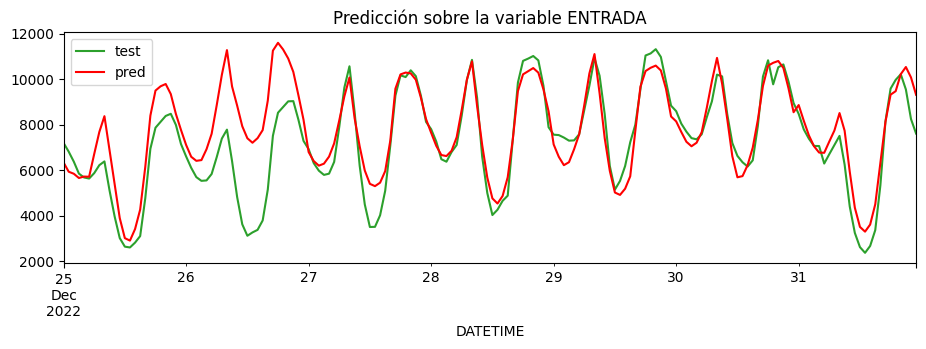

In [82]:
metrics, tiempo = backtesting(ForecasterSarimax(regressor=Sarimax(**params)), df_consumo_total, train_val_data, test_data, exog_cols = exog_cols)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, var_exog = 'Si')

+ Es importante tener en cuenta que el AIC asume que todos los modelos están entrenados con los mismos datos. Por lo tanto, usar el AIC para decidir entre diferentes órdenes de diferenciación es técnicamente inválido.

##### ***GridSearch***

In [83]:
# def grid_search_SARIMAX(forecaster, param_grid, df, train_data, validation_data):
#     resultados_grid = grid_search_sarimax(
#                             forecaster            = forecaster,
#                             y                     = df[variable].loc[:validation_data.index.max()],
#                             param_grid            = param_grid,
#                             steps                 = 12,
#                             refit                 = True,
#                             metric                = 'mean_absolute_error',
#                             initial_train_size    = len(train_data[variable]),
#                             fixed_train_size      = False,
#                             return_best           = False,
#                             n_jobs                = 'auto',
#                             suppress_warnings_fit = True,
#                             verbose               = False,
#                             show_progress         = True
#                        )
#     return resultados_grid

In [84]:
# forecaster = ForecasterSarimax(regressor=Sarimax(order=(2, 1, 4), maxiter=500))
# param_grid = {
#     'order': [(2,0,1), (2,0,2), (3,0,1), (1,0,2), (1,0,1)],
#     'seasonal_order': [(2,0,0,24), (1,0,1,24), (1,0,2,24)],
#     'trend': [None, 'n', 'c']
# }

In [85]:
# resultados_grid = grid_search_SARIMAX(forecaster, param_grid, df_consumo_total, train_data, validation_data)

### 5.4. Modelo autoregresivo recursivo con Gradient Boosting Machines (GBM): LGBMRegressor

#### 5.4.1. Creación y entrenamiento del modelo

Se entrena un modelo autorregresivo recursivo (ForecasterAutoreg) con gradient boosting LGBMRegressor como regresor. El parámetro lags es la ventana temporal que se utiliza para predecir la demanda de la hora siguiente, iteremos sobre sus valores. El resto de hiperparámetros del regresor se dejan en sus valores por defecto.

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.33636975288391113
Métricas de error: {'MAE': 1875.2190980283453, 'MSE': 5340722.438053281, 'RMSE': 2311.0003111322335}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.42107081413269043
Métricas de error: {'MAE': 1085.1673312428893, 'MSE': 2124392.0923216683, 'RMSE': 1457.5294481833525}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.8040626049041748
Métricas de error: {'MAE': 1121.1276916532913, 'MSE': 2249193.994212136, 'RMSE': 1499.7313073387966}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.1779000759124756
Métricas de error: {'MAE': 1528.651995071911, 'MSE': 4285461.00228632, 'RMSE': 2070.1355033635646}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.45499348640441895
Métricas de error: {'MAE': 1094.5428315596844, 'MSE': 1954516.3195612072, 'RMSE': 1398.0401709397363}
--------------------------------


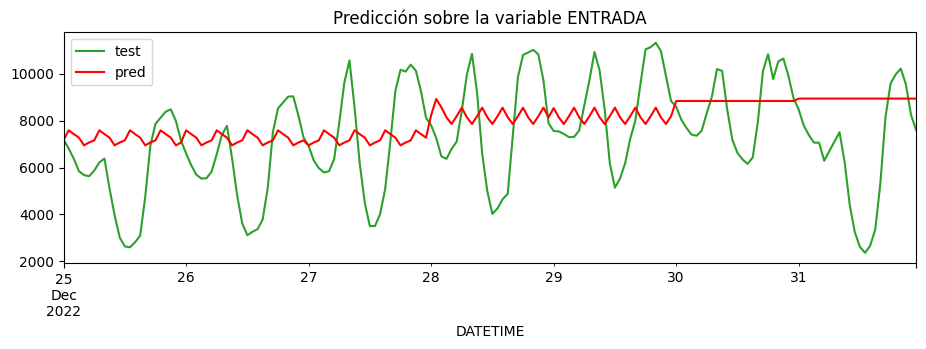

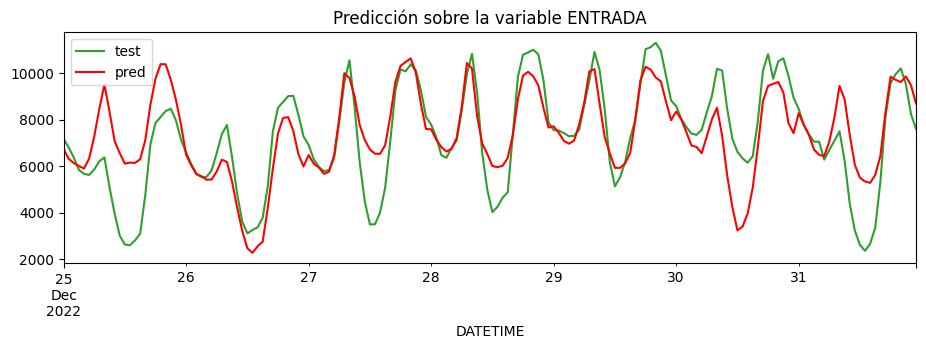

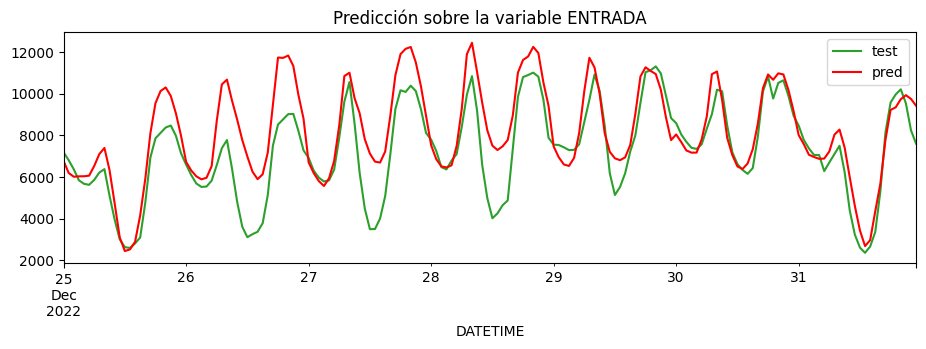

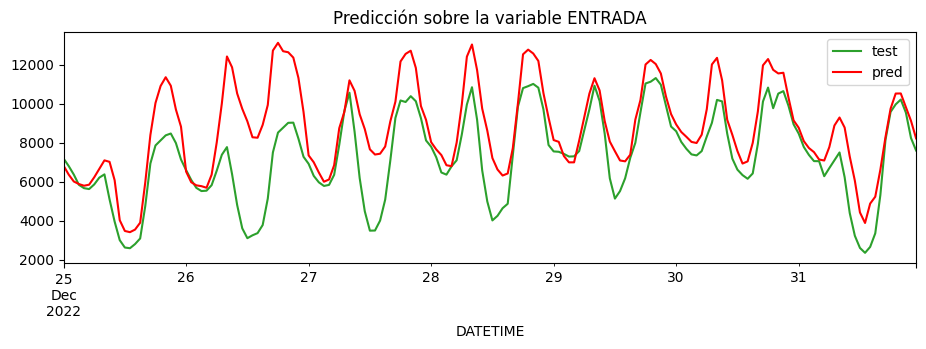

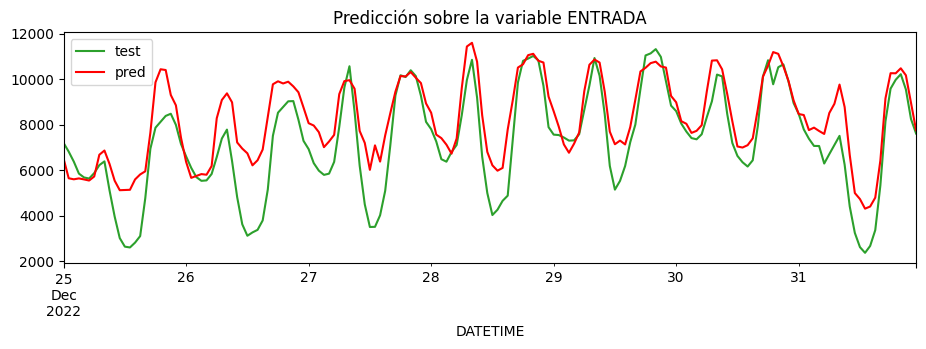

In [86]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data)
  tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

##### Con reentrenamiento

In [87]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data, grafica = False, refit = True)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 7.908995866775513
Métricas de error: {'MAE': 1869.2336627529144, 'MSE': 5490587.735646151, 'RMSE': 2343.20031914605}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.889624834060669
Métricas de error: {'MAE': 1172.8138049719414, 'MSE': 2480791.247267868, 'RMSE': 1575.0527760262091}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 13.930567264556885
Métricas de error: {'MAE': 851.032985242632, 'MSE': 1372883.9137881745, 'RMSE': 1171.7012903416016}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 20.34070348739624
Métricas de error: {'MAE': 1225.9298905197113, 'MSE': 3815800.90250446, 'RMSE': 1953.4075106092073}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.9392266273498535
Métricas de error: {'MAE': 798.4151728672111, 'MSE': 1129139.1505023097, 'RMSE': 1062.6095945841585}
--------------------------------


##### Con variables exógenas

In [88]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data, grafica = False, exog_cols = exog_cols)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.35741281509399414
Métricas de error: {'MAE': 1044.7149456897532, 'MSE': 1754232.4053161307, 'RMSE': 1324.4743883201859}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.5613980293273926
Métricas de error: {'MAE': 871.553285766818, 'MSE': 1622645.2359697826, 'RMSE': 1273.8309291149208}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.2203660011291504
Métricas de error: {'MAE': 1080.015782865459, 'MSE': 1953630.0208648578, 'RMSE': 1397.7231560165474}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.40171217918396
Métricas de error: {'MAE': 1607.1113625108974, 'MSE': 4773069.685668813, 'RMSE': 2184.7356100152742}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.7181887626647949
Métricas de error: {'MAE': 1066.7816354950323, 'MSE': 1880223.7510765628, 'RMSE': 1371.212511274807}
--------------------------------


##### Con reentrenamiento y con variables exógenas

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.3420941829681396
Métricas de error: {'MAE': 979.5219785498911, 'MSE': 1762681.862304222, 'RMSE': 1327.6602962746992}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.022371292114258
Métricas de error: {'MAE': 885.9463836262954, 'MSE': 1659254.716110475, 'RMSE': 1288.1206139606938}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 14.102996349334717
Métricas de error: {'MAE': 871.9657086529849, 'MSE': 1417772.4191021335, 'RMSE': 1190.7024897522192}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 21.684550046920776
Métricas de error: {'MAE': 1305.8765594268634, 'MSE': 4062242.811155434, 'RMSE': 2015.5006353646813}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 4.330379247665405
Métricas de error: {'MAE': 805.0648913814964, 'MSE': 1144366.2686381382, 'RMSE': 1069.7505637475206}
--------------------------------


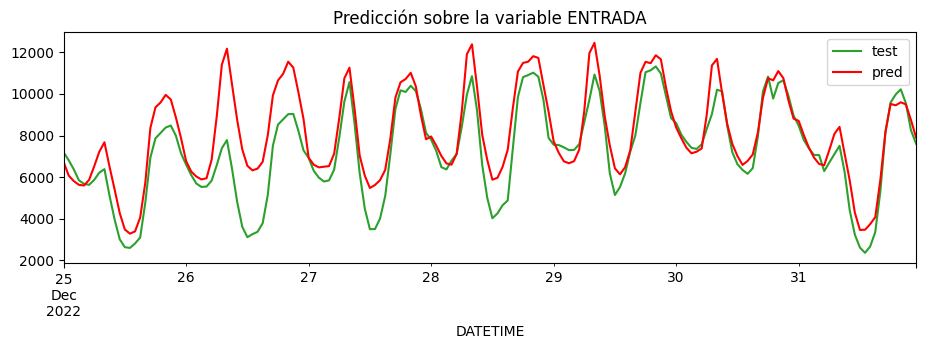

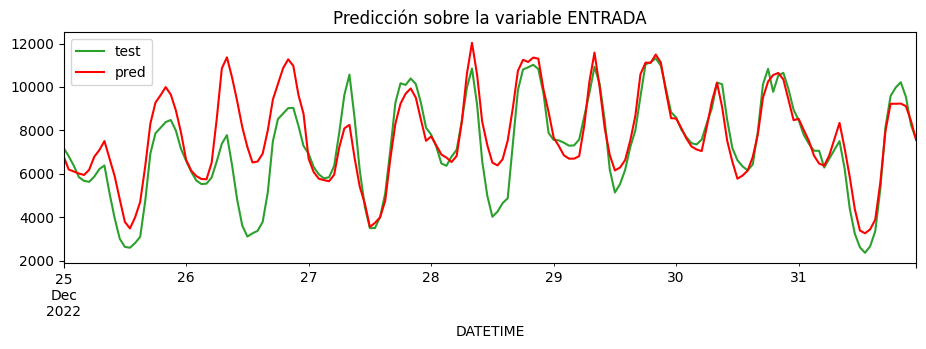

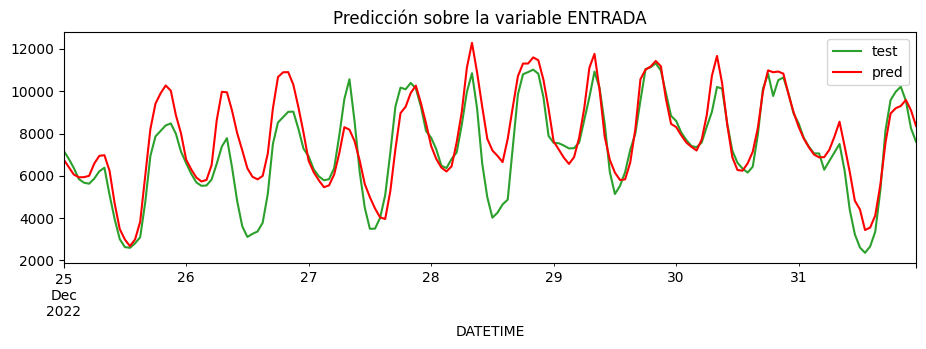

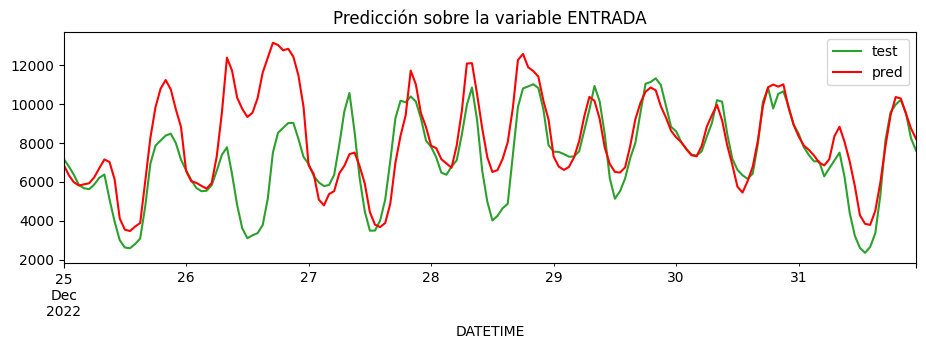

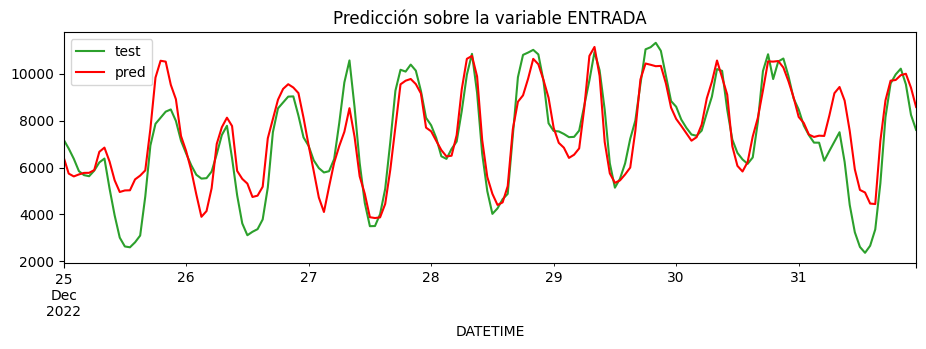

In [89]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

In [90]:
feature_importances = importancia_features(forecaster_ar_base, df_consumo_total, train_val_data)
feature_importances.head(30)

feature  importance  %_importance
671    lag_672          11          3.72
23      lag_24           9          3.04
506    lag_507           7          2.36
966    lag_967           6          2.03
627    lag_628           6          2.03
337    lag_338           5          1.69
335    lag_336           5          1.69
77      lag_78           5          1.69
1007  lag_1008           5          1.69
525    lag_526           5          1.69

Notar que el error disminuye usando más lags para la predicción y reentrenando los datos según se van haciendo las predicciones.

#### 5.4.2. Búsqueda bayesiana de hiperparámetros

*ForecasterAutoreg* tiene mucho hiperparámetros. De forma que, encontrando los mejores, podremos obtener predicciones más precisas. La búsqueda de estos hiperparámetros, se realiza mediante una Búsqueda Bayesiana con la función *bayesian_search_forecaster()*. Es importante señalar que la búsqueda de hiperparámetros debe realizarse utilizando el conjunto de validación, nunca con los datos de test.

La búsqueda se realiza probando cada combinación de hiperparámetros y retardos del siguiente modo:

1. Entrenar el modelo utilizando sólo el conjunto de entrenamiento.

2. El modelo se evalúa utilizando el conjunto de validación mediante backtesting.

3. Seleccionar la combinación de hiperparámetros y retardos que proporcione el menor error.

4. Volver a entrenar el modelo con la mejor combinación encontrada, esta vez utilizando tanto los datos de entrenamiento como los de validación.

In [91]:
lags_grid = [1, 24, 168, 720]

def search_space(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'     : max_depth,
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'num_leaves'     : trial.suggest_int('num_leaves', 2 ** max_depth, max(31, 2 ** max_depth), step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25)
    }
    return search_space

def bayesian_search(forecaster, df, train_data, validation_data, search_space):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    resultados_busqueda, frozen_trial = bayesian_search_forecaster(
                                              forecaster         = forecaster,
                                              y                  = df.loc[:validation_data.index.max(), variable], # Datos test no incluidos
                                              steps              = 24,
                                              metric             = 'mean_absolute_error',
                                              search_space       = search_space,
                                              lags_grid          = lags_grid,
                                              initial_train_size = len(train_data),
                                              refit              = False,
                                              n_trials           = 20, # Aumentar para una búsqueda más exhaustiva
                                              random_state       = 123,
                                              return_best        = True,
                                              n_jobs             = 'auto',
                                              verbose            = False,
                                              show_progress      = True
                                          )
    return resultados_busqueda

In [93]:
#try:
 # forecaster_bs = joblib.load(f'/content/drive/MyDrive/TFM/forecaster_bs_{variable}.pkl')
#except FileNotFoundError:
forecaster_bs = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = 24)
results_bayesian_search = bayesian_search(forecaster_bs, df_consumo_total, train_data, validation_data, search_space)
joblib.dump(forecaster_bs, f'/content/drive/MyDrive/TFM/forecaster_bs_{variable}.pkl')

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 10, 'n_estimators': 900, 'learning_rate': 0.4489794189784647, 'reg_alpha': 1.0, 'reg_lambda': 0.0, 'num_leaves': 1024, 'min_data_in_leaf': 28, 'feature_fraction': 0.6, 'max_bin': 75}
  Backtesting metric: 1131.338591673507



['/content/drive/MyDrive/TFM/forecaster_bs_ENTRADA.pkl']

#### 5.4.3. Backtesting del modelo con los hiperparámetros óptimos

Apliquemos ahora backtesting al modelo, utilizando los datos de train y validación como train.

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 11.979963779449463
Métricas de error: {'MAE': 944.6665170547749, 'MSE': 1591270.0327426032, 'RMSE': 1261.4555215078346}
--------------------------------


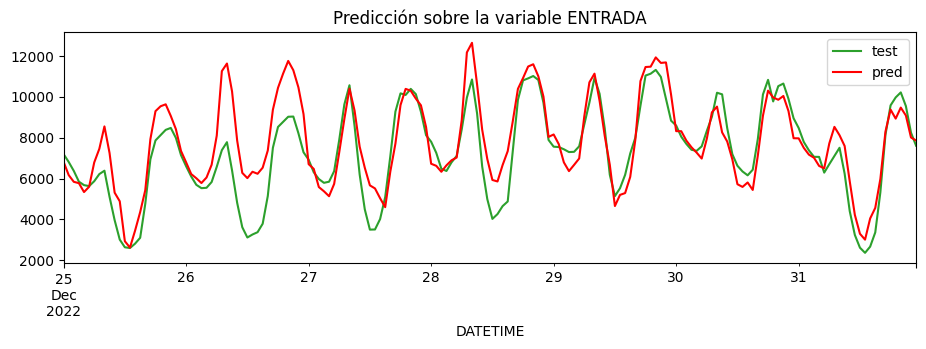

In [94]:
metrics, tiempo = backtesting(forecaster_bs, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)
tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_bs.regressor}), lags = {forecaster_bs.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

##### Forecaster direct multi-step

El modelo que hemos utilizado ForecasterAutoreg sigue una estrategia recursiva, de forma que cada nueva predicción se basa en las anteriores.
Sin embargo, podemos utilizar también el modelo ForecasterAutoregDirect, que sigue una estrategia direct multi-step forecasting y, aunque es más costosa computacionalmente debido a la necesidad de entrenar múltiples modelos, puede dar mejores resultados.

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 381.1300823688507
Métricas de error: {'MAE': 874.9599107790151, 'MSE': 1555476.963635991, 'RMSE': 1247.1876216656383}
--------------------------------


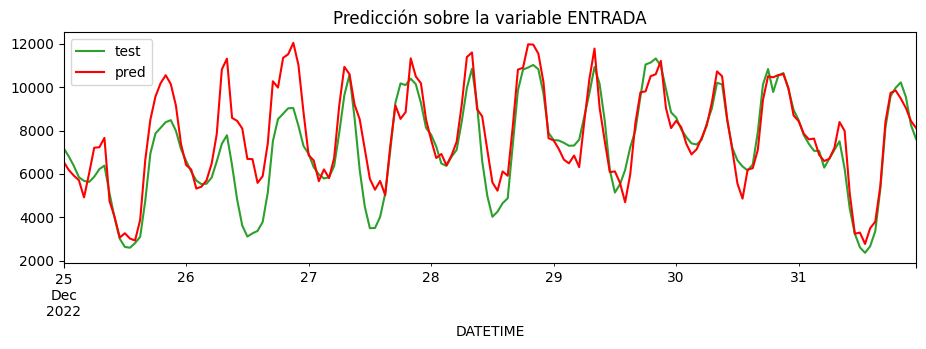

In [95]:
forecaster_direct = ForecasterAutoregDirect(regressor = LGBMRegressor(**forecaster_bs.regressor.get_params()), lags = forecaster_bs.lags, steps = 24)
metrics, tiempo = backtesting(forecaster_direct, df_consumo_total, train_val_data, test_data,refit = True, exog_cols = exog_cols)
tabla_comparacion_modelos = guardar_results(f'ForecasterAutoregDirect(regressor = {forecaster_direct.regressor}), lags = {forecaster_direct.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si', var_exog = 'Si')

### 5.5. Árboles de Decisión y Random Forest

#### 5.5.1. Creación y entrenamiento del modelo

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.2241179943084717
Métricas de error: {'MAE': 2230.6842036904764, 'MSE': 7971437.485431047, 'RMSE': 2823.3734229518855}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.5420727729797363
Métricas de error: {'MAE': 1166.9053770238097, 'MSE': 2632186.0111936135, 'RMSE': 1622.4013101552937}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 11.668627262115479
Métricas de error: {'MAE': 1121.2596921428576, 'MSE': 2346038.82098344, 'RMSE': 1531.678432629852}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 14.34380292892456
Métricas de error: {'MAE': 2090.7720970238097, 'MSE': 7836549.802142342, 'RMSE': 2799.3838254412954}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.5946388244628906
Métricas de error: {'MAE': 1230.562535595238, 'MSE': 2438565.1375855412, 'RMSE': 1561.5905793726924}
--------------------------------


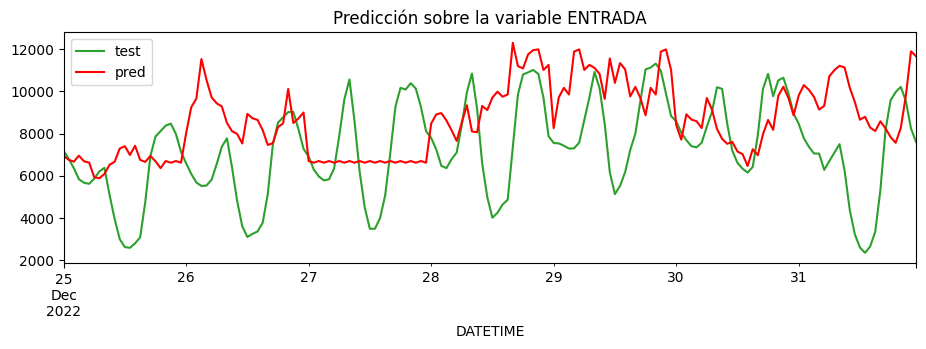

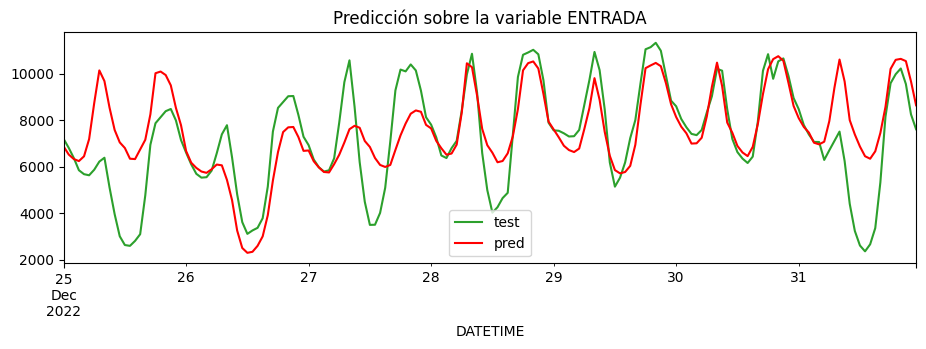

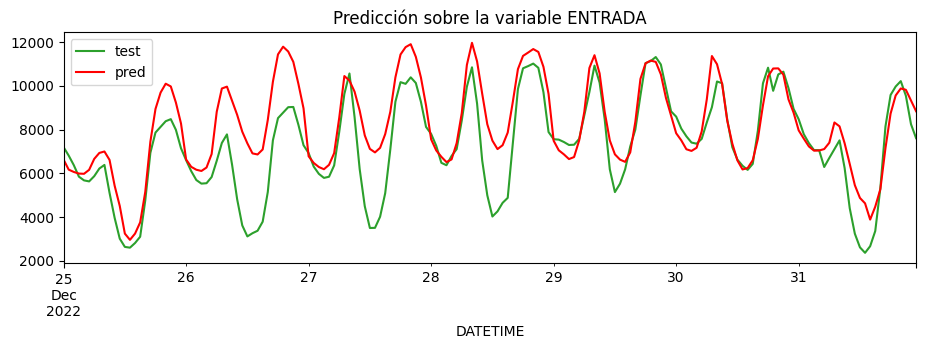

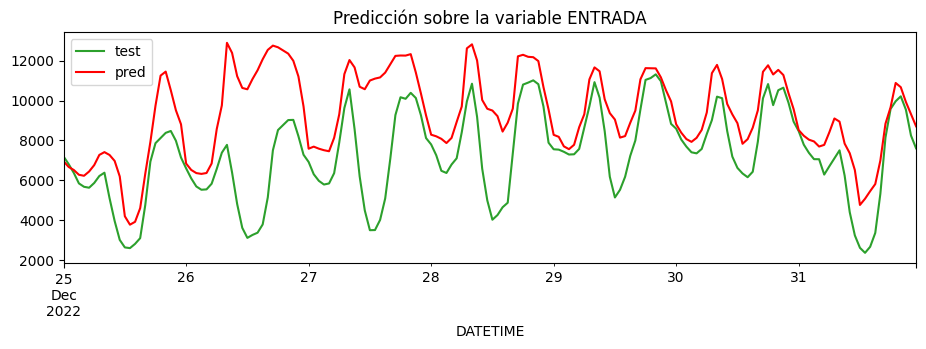

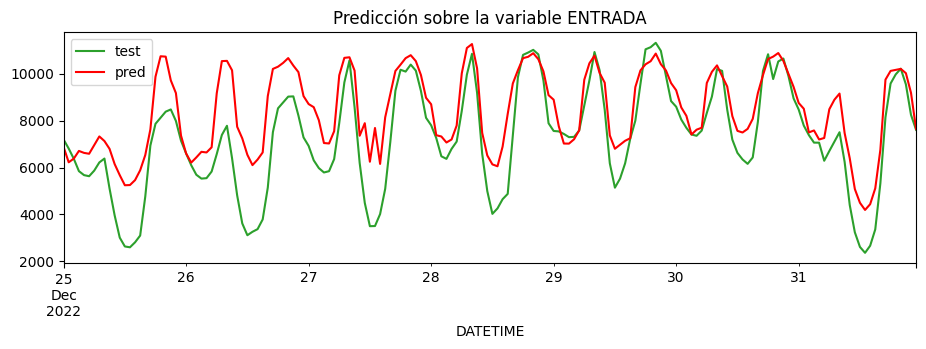

In [96]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data)
  tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

##### Con reentrenamiento

In [97]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, grafica = False, refit = True)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.72306489944458
Métricas de error: {'MAE': 2473.1987231547632, 'MSE': 9965004.106948815, 'RMSE': 3156.7394740378586}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 13.846358299255371
Métricas de error: {'MAE': 1176.8500995238096, 'MSE': 2630777.9341029697, 'RMSE': 1621.9673036479403}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 63.3306360244751
Métricas de error: {'MAE': 925.2172484523816, 'MSE': 1745979.6505049176, 'RMSE': 1321.35523251884}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 93.65191507339478
Métricas de error: {'MAE': 1683.0776157142861, 'MSE': 6105744.671283658, 'RMSE': 2470.9805080744077}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 38.5625638961792
Métricas de error: {'MAE': 962.1771705952373, 'MSE': 1713509.0143612584, 'RMSE': 1309.0107006290125}
--------------------------------


##### Con variables exógenas

In [98]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor =  RandomForestRegressor(random_state=123), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, grafica = False, exog_cols = exog_cols)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.3258376121520996
Métricas de error: {'MAE': 1108.3637301785718, 'MSE': 2136733.794993222, 'RMSE': 1461.7570916514214}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 4.0511252880096436
Métricas de error: {'MAE': 884.876563392857, 'MSE': 1481238.3471437583, 'RMSE': 1217.0613571812057}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 13.183516025543213
Métricas de error: {'MAE': 1050.5504503571437, 'MSE': 1897826.96421401, 'RMSE': 1377.6164067744003}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 15.084773302078247
Métricas de error: {'MAE': 2117.7954466071437, 'MSE': 8166751.189334033, 'RMSE': 2857.7528215949737}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.651047706604004
Métricas de error: {'MAE': 1224.4216996428574, 'MSE': 2422861.5503044734, 'RMSE': 1556.5543839854981}
--------------------------------


##### Con reentrenamiento y variables exógenas

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 14.783876419067383
Métricas de error: {'MAE': 1197.175426130953, 'MSE': 2443305.8753193878, 'RMSE': 1563.1077619023545}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 23.019706964492798
Métricas de error: {'MAE': 837.3826459523816, 'MSE': 1359915.8402394566, 'RMSE': 1166.1542952111683}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 72.55124998092651
Métricas de error: {'MAE': 976.1441588095241, 'MSE': 1856787.416211906, 'RMSE': 1362.6398703296136}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 101.77692174911499
Métricas de error: {'MAE': 1694.8846211309526, 'MSE': 6160566.649584641, 'RMSE': 2482.0488813850225}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 42.15318703651428
Métricas de error: {'MAE': 974.7244030357133, 'MSE': 1749276.56378782, 'RMSE': 1322.6021940809792}
--------------------------------


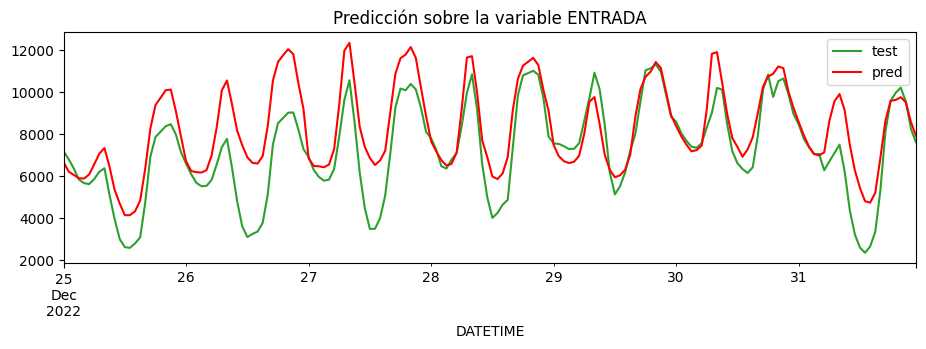

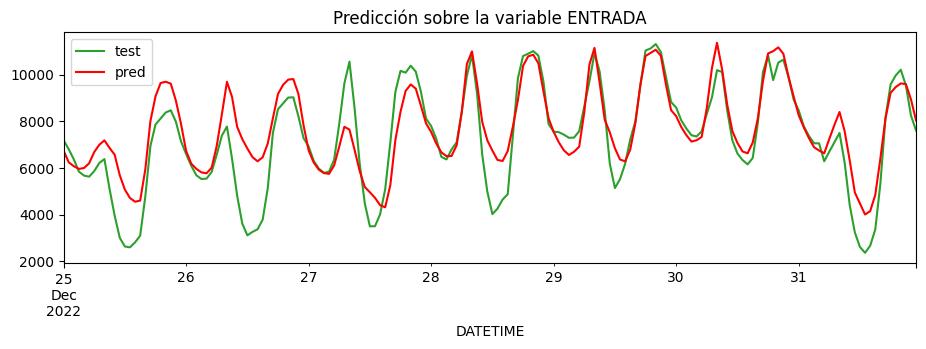

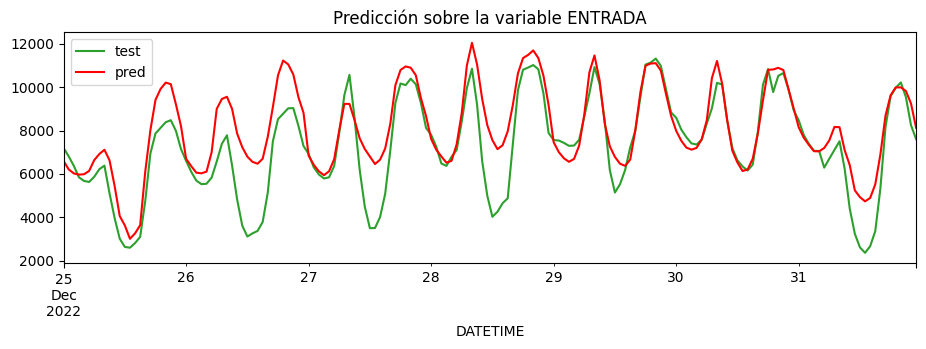

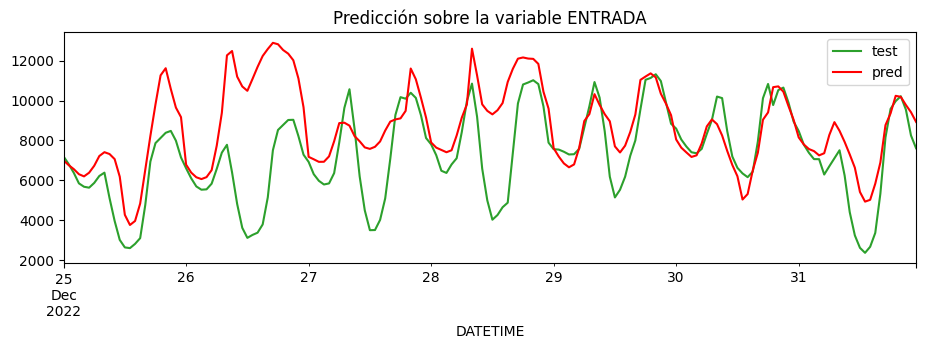

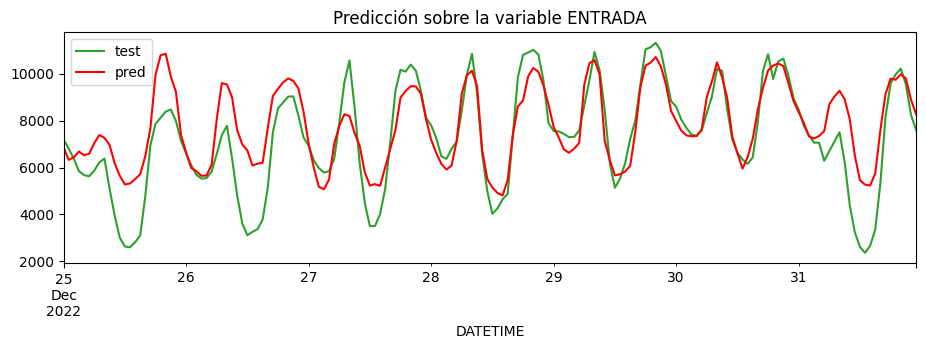

In [99]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)
  tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si', var_exog = 'Si')

#### 5.5.2. Ajuste de hiperparámetros (tuning)



In [100]:
def grid_search_ar(forecaster, steps, lags_grid, param_grid, train_data):
  resultados_grid = grid_search_forecaster(
                          forecaster         = forecaster,
                          y                  = train_data[variable],
                          param_grid         = param_grid,
                          lags_grid          = lags_grid,
                          steps              = steps,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          initial_train_size = int(len(train_data)*0.5),
                          fixed_train_size   = False, #el conjunto de entrenamiento crece a medida que se avanza en el tiempo.
                          return_best        = True,
                          n_jobs             = 'auto',
                          verbose            = False
                    )

In [101]:
steps = 24
lags_grid = [1, 24, 168]
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [3, 5, 10]
}
forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 24)
grid_search_ar(forecaster_ar_rf, steps, lags_grid, param_grid, train_data)

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 1704337.3867916868



#### 5.5.3. Backtesting

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 65.28747963905334
Métricas de error: {'MAE': 972.393915081489, 'MSE': 1828838.3162007048, 'RMSE': 1352.3454869968343}
--------------------------------


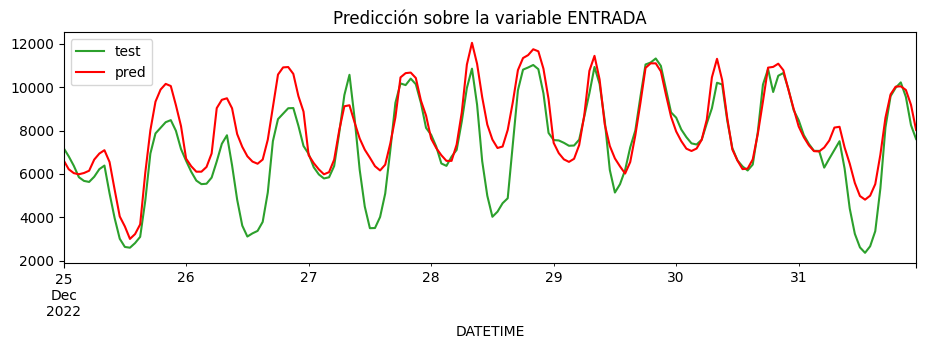

In [102]:
metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)
tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si', var_exog = 'Si')

### 5.7. Prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp32nvvvdt/_fedu97z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp32nvvvdt/vmwx02v5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98832', 'data', 'file=/tmp/tmp32nvvvdt/_fedu97z.json', 'init=/tmp/tmp32nvvvdt/vmwx02v5.json', 'output', 'file=/tmp/tmp32nvvvdt/prophet_modelcg76spsv/prophet_model-20240708203426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:34:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:34:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Métricas de error: MAE: 1107.3848519416692, MSE: 2204830.938630558, RMSE: 1484.8673134763787


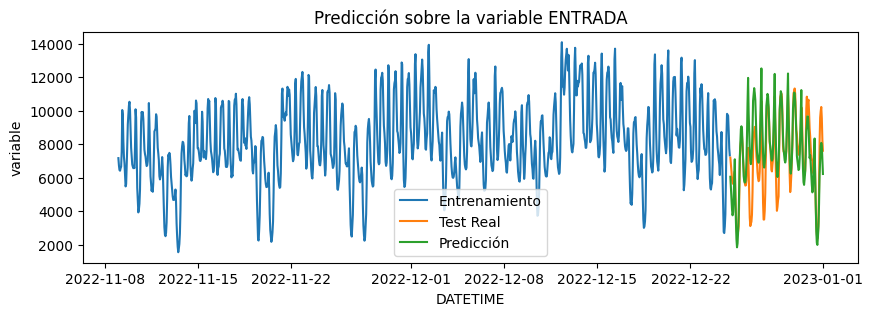

In [103]:
prophet_train = train_val_data[[variable] + exog_cols].reset_index().rename(columns={'DATETIME': 'ds', variable: 'y'})
prophet_test = test_data[[variable] + exog_cols].reset_index().rename(columns={'DATETIME': 'ds', variable: 'y'})

m = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_mode='additive', changepoint_prior_scale=0.1,
    seasonality_prior_scale=10.0)

for i in exog_cols:
    m.add_regressor(i)
m.add_country_holidays(country_name='ES')  # Usa el país correspondiente a tus datos
m.fit(prophet_train)

future = m.make_future_dataframe(periods=len(prophet_test), freq='H', include_history=True)
for col in exog_cols:
    future[col] = pd.concat([train_val_data[col], test_data[col]]).reset_index(drop=True)

forecast = m.predict(future)
forecast_test = forecast[-len(prophet_test):]

mae = mean_absolute_error(prophet_test['y'], forecast_test['yhat'])
mse = mean_squared_error(prophet_test['y'], forecast_test['yhat'])
rmse = mse ** 0.5
print(f'Métricas de error: MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

plt.figure(figsize=(10, 3))
plt.plot(prophet_train['ds'], prophet_train['y'], label='Entrenamiento')
plt.plot(prophet_test['ds'], prophet_test['y'], label='Test Real')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Predicción')
plt.xlabel('DATETIME')
plt.ylabel('variable')
plt.title(f'Predicción sobre la variable {variable}')
plt.legend()
plt.show()

## 6. Evaluación de los modelos

In [110]:
tabla_comparacion_modelos = tabla_comparacion_modelos.sort_values(by='RMSE', ascending = True)
tabla_comparacion_modelos.to_csv(f'/content/drive/MyDrive/TFM/tabla_comparacion_modelos_{variable}.csv')

In [111]:
tabla_comparacion_modelos.sort_values(by='RMSE', ascending = True)

Modelo  \
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              ForecasterSarimax(regressor=Sarimax({'order': (3, 1, 3), 'seasonal_order': (1, 1, 1, 24), 'enforce_stationarity': False})   
20                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Guardamos las predicciones del mejor modelo para poder utilizarlas.

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 626.3484306335449
Métricas de error: {'MAE': 822.7021459013877, 'MSE': 1234115.5516367366, 'RMSE': 1110.9075351426584}
--------------------------------


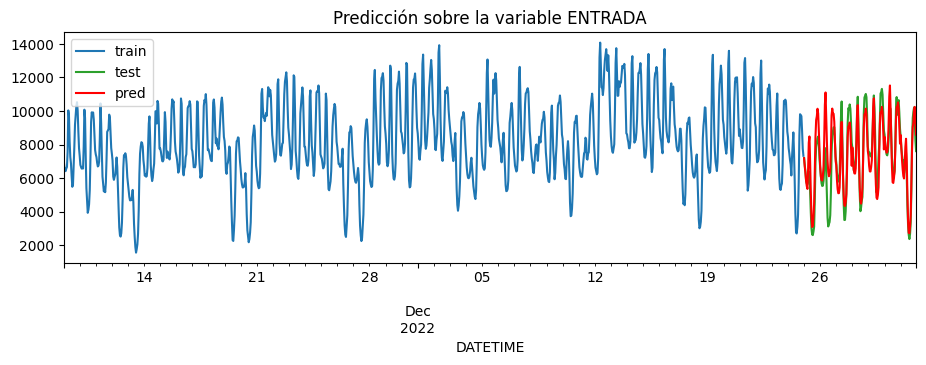

In [115]:
mejor_modelo = ForecasterSarimax(regressor=Sarimax(order = (3, 1, 3), seasonal_order = (1, 1, 1, 24), enforce_stationarity = False))
metrics, tiempo, predicciones = backtesting(mejor_modelo, df_consumo_total, train_val_data, test_data, exog_cols = exog_cols)

In [118]:
#importancia de los predictores
feature_importances = importancia_features(mejor_modelo, df_consumo_total, train_val_data)
feature_importances

feature     importance  %_importance
76                               sigma2  210688.990050         99.05
16      poly_FIN_DE_SEMANA__HORA_coseno    2273.302630          1.07
50        poly_HORA_coseno__ORTO_coseno    2163.485183          1.02
58            poly_ES_DE_DIA__ORTO_seno    2124.883575          1.00
4                             ES_DE_DIA    1815.665952          0.85
42            poly_HORA_seno__ES_DE_DIA    1572.414590          0.74
49          poly_HORA_coseno__ORTO_seno     896.145182          0.42
21       poly_FIN_DE_SEMANA__OCASO_seno     645.625081          0.30
37  poly_DIA_SEMANA_coseno__ORTO_coseno     574.674916          0.27
13  poly_FIN_DE_SEMANA__DIA_SEMANA_seno     563.599299          0.26

In [117]:
predicciones.to_csv('/content/drive/MyDrive/TFM/predictions_ENTRADA.csv', index=True)